## BETTER TRANSFORMER

Ja hem identificat tots els punts forts i el que s'ha de canviar al model per ferlo millor. Els canvis que es realitzen a aquest notebook son: 

1. Stop predicting absolute positions: better to predict velocities or displacement instead. Ara estem predint: (x_t, y_t)
Això fa que el model infereixi el speed implicitly, integri la motion implicitly i guess the trajectory scale. Per això la direcció està bé pero o undershoot o overshoot. Solució és canviar la trajectory head to predict delta positions: (dx_t, dy_t). En el codi és canviar el trajectory transformer, i sobretot canvair la multimodaltrajectoryloss. En comptes de fer diff = trajectories - gt_future.unsqueeze(1), gt_deltas = gt_future[:, 1:] - gt_future[:, :-1]
pred_deltas = trajectories[:, :, 1:] - trajectories[:, :, :-1]
Bàsicament és fer la loss amb deltas i no amb coordenades absolutes. This will fix scale errors and reduce miss rate massively, and stabilize long-horizon predicition. During inference: pred_positions = torch.cumsum(pred_deltas, dim=2)

2. Add explicit velocity supervision: ara mateix la velocitat s'apren de manera implicita. Afegiria la velocity loss: vel_pred = trajectories[:, :, 1:] - trajectories[:, :, :-1]
vel_gt   = gt_future[:, 1:] - gt_future[:, :-1]

vel_loss = F.l1_loss(vel_pred, vel_gt) i la total loss seria: total_loss = (
    reg_loss +
    0.5 * vel_loss +
    cls_loss
)
Això fa que es corregeixi el early stopping, el overshooting i el inconsistent speed. 

3. Ara mateix el que va molt malament és el FDE, per tant, millor afegir una loss que sigui del final step. final_pred = best_traj[:, -1]
final_gt   = gt_future[:, -1]

fde_loss = F.l1_loss(final_pred, final_gt)
I després sumarli això a la loss total total_loss += 2.0 * fde_loss





## Canvis de medium impact, architectural fixes

1. Normalitzar agent features to local frame: actualment el agent features utilitza les coordenades globals i això fa que la escala i la generalització no estigui bé (x, y, vx, vy). Solució és a extract_agent_features, convertir to agent-centric frame: (x, y) → local coordinates
(vx, vy) → rotated into local frame
(ax, ay) → rotated into local frame
Això seria reutilitzar el global to local i reduirà el ADE. 

2. Add a [CLS] Scene Token Instead of Using BEV as First Token, ara mateix scene_emb = encoded_tokens[:, 0] el token 0 és el BEV, not a learned aggregator. How to fix: Add:

self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))


In forward:

cls = self.cls_token.expand(B, -1, -1)
tokens = torch.cat([cls, bev_token, agent_emb, lane_emb], dim=1)


Then pool:

scene_emb = encoded[:, 0]
This stabilizes attention + improves multimodal separation.

3. Mask padding agents properly: Right now we are padding agents with 0 but we dont mask them. Create a mask: agent_mask = (agent_features.abs().sum(dim=-1) == 0)
src_key_padding_mask = torch.cat([
    cls_mask,
    bev_mask,
    agent_mask,
    lane_mask
], dim=1)
This prevents attention pollution and cleaner scene coding. 




## Acabar map and lane improvements

1. Add lane direction alignment loss: for final displacement vector: cos_sim = cosine(pred_dir, lane_dir)
lane_loss = 1 - cos_sim i afegirlo a la total loss: total_loss += 0.3 * lane_loss
 Això reduirà els wrong turns, el diagonal drift at intersections. 

2. Use lane tokens as queries (optional but strong): instead of concatenating lanes passively: let agent attend to lanes, lane-aware decoding. This is LaneGCN + transformer hybrids. Lane-aware decoding


## Multimodality fixes (WHY MISSRATE HHUGE): 

1. Increase number of modes (o 6 o 8): NUM_MODES = 6 or 8 i també increase la classification_weight perque necessitem multimodality for intersections. classification_weight = 2.0

2. Diversity loss between models: to prevent mode collapse: div_loss = mean_pairwise_distance(final_points)
total_loss += 0.1 * div_loss



## Training optimization improvewments: 
1. Curriculum learning: train in stages (primer 2 segons, després 4 i després 6). Gradually increase num_steps. 

2. DONE: Stronger regularization: dropout = 0.2
weight_decay = 1e-4, scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS) 

🧪 Debug & Sanity Checks (Do These Once)

Plot predicted speed vs GT speed

Plot trajectory length ratio

Histogram of final displacement magnitude

If these look aligned → model is fixed.



### IMPORTS

In [29]:
import sys
import os
from pathlib import Path

current_path = Path(os.getcwd())

project_root = current_path.parent.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Working in: {current_path}")
print(f"Root of the project: {project_root}")

try:
    import nuimages 
    import nuscenes
except ImportError as e:
    print(f"Error: {e}")

Working in: /root/nuscenes-devkit/python-sdk/main/notebooks
Root of the project: /root/nuscenes-devkit/python-sdk


In [30]:
import argparse
import pickle
from nuscenes import NuScenes
import os
import json
from nuscenes.map_expansion.map_api import NuScenesMap

from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
import torch
import numpy as np
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle
from nuscenes.eval.prediction.data_classes import Prediction

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.metrics import MinADEK, MinFDEK, RowMean
from nuscenes.prediction.models.backbone import ResNetBackbone

from matplotlib import pyplot as plt

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle

from nuscenes.map_expansion import arcline_path_utils
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet

from torch.utils.data import Dataset, DataLoader
from nuscenes.prediction.models.mtp import MTPLoss

MINI wayformer a partir d'embeddings

Primer s'ha hagut de fer els embeddings i concatenarlos. 

In [1]:
# shapes de entrada al Transformer (que prepararás después)
# bev_emb:      (batch_size, 1, D)
# agent_embs:   (batch_size, N_agents, D)
# lane_embs:    (batch_size, N_lanes, D)

# y luego los concatenas:
# tokens = torch.cat([bev_emb, agent_embs, lane_embs], dim=1)  # (B, T, D)


### agent embedding:

CADA AGENT TÉ AIXÒ: posición (x, y), velocidad, aceleración, heading (ángulo), tamaño (width, length),clase (car, pedestrian, bicycle…), historia pasada (opcional), estado actual (si está quieto o no, etc.)

amb una dimensionalidad podriem tenir un feature vector així: [x, y, vx, vy, ax, ay, heading_sin, heading_cos, width, length]


In [16]:
def extract_agent_features_ANTIGUA(helper, instance_token, sample_token):
    ann = helper.get_sample_annotation(instance_token, sample_token)

    # Position
    x, y, _ = ann["translation"]

    # Velocity
    vx, vy = helper.get_velocity_for_agent(instance_token, sample_token)

    # Acceleration
    ax, ay = helper.get_acceleration_for_agent(instance_token, sample_token)

    # Heading (convert quaternion → sin/cos)
    quat = ann["rotation"]  # [qw, qx, qy, qz]
    yaw = Quaternion(quat).yaw_pitch_roll[0]
    sin_yaw = np.sin(yaw)
    cos_yaw = np.cos(yaw)

    # Size
    width, length, _ = ann["size"]

    # Feature vector
    features = np.array([x, y, vx, vy, ax, ay, sin_yaw, cos_yaw, width, length], dtype=np.float32)

    return features  # shape (10,)

def global_to_local_point(point_xy, ego_translation, ego_rotation):
    """
    point_xy: (2,)
    ego_translation: [x, y, z]
    ego_rotation: quaternion
    """
    q_inv = Quaternion(ego_rotation).inverse
    p = np.array([point_xy[0] - ego_translation[0],
                  point_xy[1] - ego_translation[1],
                  0.0])
    p_local = q_inv.rotate(p)
    return np.array(p_local[:2], dtype=np.float32)


def rotate_vector_to_local(vx, vy, ego_rotation):
    """
    Rotates a velocity or acceleration vector into ego-local frame.
    """
    q_inv = Quaternion(ego_rotation).inverse
    v = np.array([vx, vy, 0.0])
    v_local = q_inv.rotate(v)
    return np.array(v_local[:2], dtype=np.float32)

def extract_agent_features(helper, instance_token, sample_token,
                           ego_translation, ego_rotation):

    ann = helper.get_sample_annotation(instance_token, sample_token)

    # --- GLOBAL POSITION ---
    x, y, _ = ann["translation"]

    # --- GLOBAL VELOCITY ---
    vx, vy = helper.get_velocity_for_agent(instance_token, sample_token)
    if np.isnan(vx): vx = 0.0
    if np.isnan(vy): vy = 0.0

    # --- GLOBAL ACCELERATION ---
    ax, ay = helper.get_acceleration_for_agent(instance_token, sample_token)
    if np.isnan(ax): ax = 0.0
    if np.isnan(ay): ay = 0.0

    # --- HEADING ---
    quat = ann["rotation"]
    yaw = Quaternion(quat).yaw_pitch_roll[0]
    sin_yaw = np.sin(yaw)
    cos_yaw = np.cos(yaw)

    # --- SIZE ---
    width, length, _ = ann["size"]

    # ======================================================
    # 🔥 LOCAL FRAME TRANSFORMATION (KEY CHANGE)
    # ======================================================
    pos_local = global_to_local_point(
        np.array([x, y]),
        ego_translation,
        ego_rotation
    )

    vel_local = rotate_vector_to_local(vx, vy, ego_rotation)
    acc_local = rotate_vector_to_local(ax, ay, ego_rotation)

    # --- FINAL FEATURE VECTOR ---
    features = np.array([
        pos_local[0], pos_local[1],
        vel_local[0], vel_local[1],
        acc_local[0], acc_local[1],
        sin_yaw, cos_yaw,
        width, length
    ], dtype=np.float32)

    return features  # (10,)


## PASSAR TOTS ELS AGENTS PER UN MLP PER TENIR AGENT EMBEDDING DE agent embedding (B, N_agents, D)
class AgentEncoder(nn.Module):
    def __init__(self, in_dim=10, hidden_dim=128, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, agent_features):
        """
        agent_features: (B, N_agents, 10)
        returns: (B, N_agents, out_dim)
        """
        return self.mlp(agent_features)

MAX_AGENTS = 12  # como Waymo, puedes escoger 12–16

def build_agent_embeddings(helper, sample_token, agent_encoder, device):
    anns = helper.get_annotations_for_sample(sample_token)

    features = []

    for ann in anns:
        instance_token = ann["instance_token"]
        f = extract_agent_features(helper, instance_token, sample_token)
        features.append(f)

        if len(features) == MAX_AGENTS:
            break

    # Padding
    while len(features) < MAX_AGENTS:
        features.append(np.zeros(10, dtype=np.float32))

    features = torch.tensor(features, device=device)  # (MAX_AGENTS, 10)
    features = features.unsqueeze(0)  # (1, MAX_AGENTS, 10)

    # Agent Encoder
    with torch.no_grad():  # or leave gradients if end-to-end
        agent_emb = agent_encoder(features)  # (1, MAX_AGENTS, d_model)

    return agent_emb  # shape (1, N_agents, d_model)


### Lane embeddings

L'objectiu és donat un sample_token lane_emb: (1, N_lanes, d_model). Cada lane a nuscenes es un polyline ([(x1, y1), (x2, y2), ..., (xk, yk)])
cADA LANE TIENE Type,conexiones, direccion del trafico y curbatura

Pero la mínima base funcional para un Transformer es:

✔ samplear la polilínea
✔ convertir cada punto a un feature
✔ agregar todos los puntos para crear un embedding por lane

Obtenim les polylines més properes al agent

In [18]:
def get_relevant_lanes(helper, agent_x, agent_y, max_lanes=8):
    """
    Returns up to max_lanes lane IDs near the agent.
    """
    lane_ids = helper.map_api.get_lane_ids_in_xy(agent_x, agent_y)

    # If too many lanes, keep closest N
    if len(lane_ids) > max_lanes:
        lane_ids = lane_ids[:max_lanes]

    return lane_ids


Treiem la polilínea de cada agent

In [19]:
def get_lane_polyline(helper, lane_id):
    # returns Nx2 array with (x, y)
    poly = helper.map_api.get_lane_centerline(lane_id)[:, :2]
    return poly  # shape (K, 2)


Convertim cada polilínea en un conjunt de features (com es fa a implementacions com LaneGCN y Vectornet)
dx, dy                 → dirección del segmento
length                 → distancia
norm direction         → dx / length, dy / length
curvature              → change of angle (si queremos)


In [20]:
import numpy as np

def polyline_to_features(poly):
    """
    poly: (K,2)
    returns features for each segment: (K-1, 5)
    """
    segments = []
    for i in range(len(poly) - 1):
        x1, y1 = poly[i]
        x2, y2 = poly[i+1]

        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx*dx + dy*dy) + 1e-6
        nx = dx / length
        ny = dy / length

        # Feature per segment
        feat = [dx, dy, length, nx, ny]
        segments.append(feat)

    return np.array(segments, dtype=np.float32)  # (K-1, 5)


Ara MLP com abans per fer el lane encoder. 

In [21]:
class LaneSegmentEncoder(nn.Module):
    def __init__(self, in_dim=5, hidden_dim=128, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, seg_features):
        """
        seg_features: (num_segments, in_dim)
        returns: (num_segments, out_dim)
        """
        return self.mlp(seg_features)


In [22]:
def aggregate_lane_embedding(segment_embs):
    """
    segment_embs: (num_segments, d_model)
    returns a single lane embedding: (d_model,)
    """
    return segment_embs.mean(dim=0)  # or max(dim=0)[0]


In [23]:
def build_lane_embedding(helper, lane_id, lane_encoder, device):
    # 1. Polyline
    poly = get_lane_polyline(helper, lane_id)  # (K,2)

    seg_feats = polyline_to_features(poly)     # (K-1, 5)
    seg_feats = torch.tensor(seg_feats, device=device)

    # 2. Encode each segment
    seg_embs = lane_encoder(seg_feats)         # (K-1, d_model)

    # 3. Aggregate segment embeddings
    lane_emb = seg_embs.mean(dim=0)            # (d_model,)

    return lane_emb


Hacemos embedings para todos los lanes

In [24]:
MAX_LANES = 8

def build_lane_embeddings(helper, agent_x, agent_y, lane_encoder, device):
    lane_ids = get_relevant_lanes(helper, agent_x, agent_y, max_lanes=MAX_LANES)

    lane_embs = []
    for lane_id in lane_ids:
        emb = build_lane_embedding(helper, lane_id, lane_encoder, device)
        lane_embs.append(emb)

    # Padding
    while len(lane_embs) < MAX_LANES:
        lane_embs.append(torch.zeros(lane_embs[0].shape, device=device))

    lane_embs = torch.stack(lane_embs, dim=0)  # (MAX_LANES, d_model)
    lane_embs = lane_embs.unsqueeze(0)         # (1, MAX_LANES, d_model)

    return lane_embs


El resultado tendria que ser un sistema on el lane_emb :(1,N_lanes, d_model)

### Bird Eye View embedding

Aquest embedding hauria de ser un tensor que resumeixi tota la escena. bev_emb: (1, 1, d_model)

La imatge rasterizada en vista cenital ja està implementada a nuscnees: 

In [33]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/root/nuscenes-devkit/data/sets/nuscenes'

nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.246 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [34]:
helper = PredictHelper(nuscenes)
static_layer_rasterizer = StaticLayerRasterizer(helper)
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())
img = mtp_input_representation.make_input_representation(instance_token, sample_token)


NameError: name 'instance_token' is not defined

La imatge que produeix el multicanal d'unes dimensions com: (3, 224, 224)    o (3, 500, 500)  según configuración
    

Això se li pasa a una resnet (cnn) treiem un embedding i el reduim a d_model i serà el primer token del transformer

In [35]:
import torchvision.models as models
import torch.nn as nn
import torch

"""

"""
class BEVBackbone(nn.Module):
    def __init__(self, out_dim=128, arch="resnet18"):
        super().__init__()

        if arch == "resnet18":
            base = models.resnet18(weights=None)
            feat_dim = 512
        elif arch == "resnet50":
            base = models.resnet50(weights=None)
            feat_dim = 2048
        else:
            raise ValueError("Unsupported backbone")

        # Remove final FC layer, keep convolutional trunk
        self.cnn = nn.Sequential(*list(base.children())[:-1])  # output: (B, feat_dim, 1, 1)

        # MLP to project onto transformer dimension
        self.proj = nn.Linear(feat_dim, out_dim)

    def forward(self, bev_img):
        """
        bev_img: (B, C, H, W)
        returns: (B, out_dim)
        """
        x = self.cnn(bev_img)         # (B, feat_dim, 1, 1)
        x = x.view(x.size(0), -1)     # (B, feat_dim)
        x = self.proj(x)              # (B, out_dim)
        return x


In [36]:
class BEVEncoder(nn.Module):
    def __init__(self, input_representation, d_model=128, arch="resnet18", device="cpu"):
        super().__init__()
        self.input_representation = input_representation
        self.device = device

        # CNN backbone to extract features
        self.backbone = BEVBackbone(out_dim=d_model, arch=arch).to(device)

    def forward(self, instance_token, sample_token):
        """
        Returns:
            bev_token: (1, 1, d_model)
        """

        # 1) Rasterize nuScenes BEV image
        img = self.input_representation.make_input_representation(
            instance_token, sample_token
        )   # numpy array (H, W, C)

        # 2) Convert → torch tensor
        bev_img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C,H,W)
        bev_img = bev_img.unsqueeze(0).to(self.device)                    # (1,C,H,W)

        # 3) Normalize (IMPORTANT — like ImageNet)
        bev_img = (bev_img - bev_img.mean()) / (bev_img.std() + 1e-6)

        # 4) Extract embedding using CNN backbone
        bev_emb = self.backbone(bev_img)   # (1, d_model)

        # 5) Convert to a single transformer token → (1,1,d_model)
        bev_token = bev_emb.unsqueeze(1)

        return bev_token


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bev_encoder = BEVEncoder(
    input_representation=mtp_input_representation,
    d_model=128,
    arch="resnet18",
    device=device
)

# OBTENER TOKEN PARA UN SAMPLE
# bev_token = bev_encoder(instance_token, sample_token)
# print(bev_token.shape)

# la sortida hauria de ser: torch.Size([1, 1, 128])



In [40]:
def build_bev_embedding(self, instance_token, sample_token):
    
    # 1. Rasterize BEV image (you already do this)
    img = self.input_representation.make_input_representation(
        instance_token, sample_token
    )  # numpy array (H, W, C)

    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)
    img = img.unsqueeze(0).to(self.device)  # (1, C, H, W)

    # 2. Backbone CNN → embedding
    bev_emb = self.bev_backbone(img)        # (1, d_model)

    # 3. Convert to transformer token
    bev_token = bev_emb.unsqueeze(1)        # (1, 1, d_model)

    return bev_token


Agreguem tots els embeddings

In [ ]:
tokens = torch.cat([bev_emb, agent_emb, lane_emb], dim=1)


### Transformer

Després només fa falta el model transformer i el head de predicció de trajectories. 

In [41]:
import math
import torch
from torch import nn
from torch.nn import functional as F


class PositionalEncoding(nn.Module):
    """
    Standard sine-cosine positional encoding from the "Attention is All You Need" paper.
    Adds position information to each token in the sequence.
    """

    def __init__(self, d_model: int, max_len: int = 256):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # shape -> (1, max_len, d_model) to broadcast over batch
        self.register_buffer("pe", pe.unsqueeze(0))  

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        # Add positional encoding to the input embeddings
        x = x + self.pe[:, :seq_len, :]
        return x


class TrajectoryTransformer(nn.Module):
    """
    Transformer-based trajectory prediction model.

    Inputs:
        - token_embeddings: (batch_size, seq_len, d_model)
          Sequence of tokens from:
            * 1 BEV embedding
            * N agent embeddings
            * M lane embeddings

    Outputs:
        - trajectories: (batch_size, num_modes, num_steps, 2)
        - mode_logits (optional): (batch_size, num_modes)
    """

    def __init__(
        self,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        dropout: float = 0.2, # BEFORE IT WAS 0.1
        num_modes: int = 1,
        num_steps: int = 12,
        use_mode_head: bool = True,
    ):
        super().__init__()

        self.d_model = d_model
        self.num_modes = num_modes
        self.num_steps = num_steps
        self.use_mode_head = use_mode_head
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))


        # Positional encoding for the sequence tokens
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=256)

        # Transformer encoder (no decoder needed, we just encode the scene)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # input/output shape = (batch, seq, d_model)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.lane_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=4,
            batch_first=True
        )


        # We will use the "scene token" representation to decode trajectories.
        # Typically we take the first token (e.g. BEV or a special [CLS]-like token).
        self.scene_pool = "first"  # could be 'mean' if you want average pooling

        # Head that maps the scene embedding to future trajectories
        # Output size = num_modes * num_steps * 2 (x, y)
        self.traj_head = nn.Linear(d_model, num_modes * num_steps * 2)

        # Optional mode classification head (for multi-modal prediction)
        if use_mode_head and num_modes > 1:
            self.mode_head = nn.Linear(d_model, num_modes)
        else:
            self.mode_head = None

    def _pool_scene_token(self, encoded_tokens: torch.Tensor) -> torch.Tensor:
        """
        encoded_tokens: (batch_size, seq_len, d_model)
        Returns:
            scene_emb: (batch_size, d_model)
        """
        if self.scene_pool == "first":
            # Take the first token (assumed to be the BEV / global context token)
            scene_emb = encoded_tokens[:, 0, :]
        elif self.scene_pool == "mean":
            scene_emb = encoded_tokens.mean(dim=1)
        else:
            raise ValueError(f"Unknown scene_pool mode: {self.scene_pool}")
        return scene_emb

    def forward(
        self,
        token_embeddings: torch.Tensor,
        src_key_padding_mask: torch.Tensor | None = None,
        num_agents: int | None = None,
        num_lanes: int | None = None,
    ):
        """
        Args:
            token_embeddings: (B, 1 + N_agents + N_lanes, D)
            src_key_padding_mask: (B, 1 + N_agents + N_lanes)
            num_agents: number of agent tokens
            num_lanes: number of lane tokens
        """

        B, T, D = token_embeddings.shape

        assert num_agents is not None and num_lanes is not None, \
            "num_agents and num_lanes must be provided for lane-aware attention"

        # --------------------------------------------------
        # 1️⃣ Positional Encoding
        # --------------------------------------------------
        B = token_embeddings.size(0)
        cls = self.cls_token.expand(B, -1, -1)   # (B,1,D)
        tokens = torch.cat([cls, token_embeddings], dim=1)  # (B, 1+T, D)
        # 2️⃣ Afegir CLS mask
        if src_key_padding_mask is not None:
            cls_mask = torch.zeros((B, 1), device=src_key_padding_mask.device).bool()
            src_key_padding_mask = torch.cat(
                [cls_mask, src_key_padding_mask],
                dim=1
            )  # (B, 1+T)
        x = self.pos_encoder(tokens)

        # --------------------------------------------------
        # 2️⃣ Transformer Encoder (Scene Encoding)
        # --------------------------------------------------
        encoded = self.transformer_encoder(
            x,
            src_key_padding_mask=src_key_padding_mask
        )  # (B, T, D)

        # --------------------------------------------------
        # 3️⃣ Split tokens (VERY IMPORTANT)
        # --------------------------------------------------
        bev_token = encoded[:, 0:1, :]                       # (B, 1, D)
        agent_tokens = encoded[:, 1:1 + num_agents, :]       # (B, N_agents, D)
        lane_tokens = encoded[:, 1 + num_agents:, :]         # (B, N_lanes, D)

        # Target agent = first agent token
        agent_token = agent_tokens[:, 0:1, :]                # (B, 1, D)

        # --------------------------------------------------
        # 4️⃣ Lane-aware Cross Attention (KEY STEP)
        # --------------------------------------------------
        # Agent queries lanes
        lane_context, _ = self.lane_attention(
            query=agent_token,    # (B, 1, D)
            key=lane_tokens,      # (B, N_lanes, D)
            value=lane_tokens,    # (B, N_lanes, D)
            key_padding_mask=(
                src_key_padding_mask[:, 1 + num_agents:]
                if src_key_padding_mask is not None else None
            )
        )  # (B, 1, D)

        # --------------------------------------------------
        # 5️⃣ Scene embedding (Lane-aware)
        # --------------------------------------------------
        # Base scene = BEV token
        scene_emb = bev_token.squeeze(1)          # (B, D)

        # Inject lane context
        scene_emb = scene_emb + lane_context.squeeze(1)  # (B, D)

        # --------------------------------------------------
        # 6️⃣ Trajectory Head
        # --------------------------------------------------
        traj_flat = self.traj_head(scene_emb)  # (B, M * T * 2)

        trajectories = traj_flat.view(
            B, self.num_modes, self.num_steps, 2
        )

        # --------------------------------------------------
        # 7️⃣ Mode logits (optional)
        # --------------------------------------------------
        mode_logits = None
        if self.mode_head is not None:
            mode_logits = self.mode_head(scene_emb)

        return trajectories, mode_logits



In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiModalTrajectoryLoss(nn.Module):
    def __init__(self, regression_weight=1.0, classification_weight=1.0, lane_weight=0.3):
        super().__init__()
        self.reg_weight = regression_weight
        self.cls_weight = classification_weight
        self.lane_weight = lane_weight
        self.reg_loss_fn = nn.SmoothL1Loss()

    def diversity_loss_final_points(self,trajectories):
        """
        trajectories: (B, M, T, 2)
        """
        final_pts = trajectories[:, :, -1, :]  # (B, M, 2)

        diffs = final_pts.unsqueeze(2) - final_pts.unsqueeze(1)  # (B, M, M, 2)
        dists = torch.norm(diffs, dim=-1)                         # (B, M, M)

        # quitar diagonal
        M = trajectories.size(1)
        mask = ~torch.eye(M, device=trajectories.device).bool()
        dists = dists[:, mask].view(trajectories.size(0), M, M-1)

        return dists.mean()


    def forward(self, trajectories, mode_logits, gt_future, lane_dirs=None):
        """
        trajectories: (B, M, T, 2)
        mode_logits:  (B, M)
        gt_future:    (B, T, 2)
        lane_dirs:    (B, N_lanes, 2) in LOCAL frame
        """

        B, M, T, _ = trajectories.shape

        # ---- STEP 1: best mode by ADE ----
        diff = trajectories - gt_future.unsqueeze(1)      # (B,M,T,2)
        l2 = torch.norm(diff, dim=-1)                    # (B,M,T)
        ade = l2.mean(dim=-1)                            # (B,M)
        best_mode = ade.argmin(dim=1)                    # (B,)

        # ---- STEP 2: regression on best mode ----
        best_traj = trajectories[torch.arange(B), best_mode]  # (B,T,2)
        reg_loss = self.reg_loss_fn(best_traj, gt_future)

        final_pred = best_traj[:, -1]   # (B,2)
        final_gt   = gt_future[:, -1]   # (B,2)

        fde_loss = F.l1_loss(final_pred, final_gt)


        # ---- STEP 3: classification ----
        cls_loss = F.cross_entropy(mode_logits, best_mode)

        div_loss = self.diversity_loss_final_points(trajectories)

        # ---- STEP 4: lane direction alignment (optional) ----
        lane_loss = torch.tensor(0.0, device=trajectories.device)

        if lane_dirs is not None:
            lane_dirs = lane_dirs.to(trajectories.device)  # (B,N,2)

            # Pred final displacement direction
            pred_disp = best_traj[:, -1] - best_traj[:, 0]      # (B,2)
            pred_dir = F.normalize(pred_disp, dim=-1, eps=1e-6) # (B,2)

            # Normalize lane dirs (avoid zeros)
            lane_dirs_norm = F.normalize(lane_dirs, dim=-1, eps=1e-6)  # (B,N,2)

            # Cosine similarity pred_dir vs each lane dir
            cos_sim = torch.einsum("bd,bnd->bn", pred_dir, lane_dirs_norm)  # (B,N)

            # Mask padded lanes: padded dirs are (0,0) -> norm becomes 0-ish; still not reliable.
            # Better: detect padded lanes and force their sim to -1 so they never win.
            lane_pad = (lane_dirs.abs().sum(dim=-1) < 1e-8)  # (B,N) True if padded
            cos_sim = cos_sim.masked_fill(lane_pad, -1.0)

            best_lane_sim, _ = cos_sim.max(dim=1)  # (B,)
            lane_loss = (1.0 - best_lane_sim).mean()

        total_loss = (
            self.reg_weight * reg_loss
            + self.cls_weight * cls_loss
            + self.lane_weight * lane_loss
            + 0.1 * div_loss
            + 0.2 * fde_loss
        )

        return total_loss, reg_loss.detach(), cls_loss.detach(), lane_loss.detach(), best_mode


In [55]:
import torch
from torch.utils.data import Dataset
import numpy as np
from pyquaternion import Quaternion

class NuScenesTransformerDataset(Dataset):
    def __init__(self, helper, split_name='train_mini', max_agents=12, max_lanes=8):
        self.helper = helper
        self.split_name = split_name
        self.max_agents = max_agents
        self.max_lanes = max_lanes
        
        self.token_list = get_prediction_challenge_split(
            split_name, dataroot=helper.data.dataroot
        )
        
        self.static_rasterizer = StaticLayerRasterizer(helper)
        self.agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
        self.input_rep = InputRepresentation(
            self.static_rasterizer, self.agent_rasterizer, Rasterizer()
        )

    def __len__(self):
        return len(self.token_list)

    # ------------------------------------------------
    # 🔁 Coordinate transforms
    # ------------------------------------------------
    def global_to_local(self, origin_translation, origin_rotation, points_global):
        points_global = np.array(points_global)
        if points_global.ndim == 1:
            points_global = points_global[None, :]
            
        points_centered = points_global - origin_translation[:2]
        q_inv = Quaternion(origin_rotation).inverse
        
        points_local = []
        for p in points_centered:
            p_3d = np.array([p[0], p[1], 0.0])
            p_rot = q_inv.rotate(p_3d)
            points_local.append(p_rot[:2])
            
        return np.array(points_local, dtype=np.float32)

    # ------------------------------------------------
    # 🛣️ Lane utilities
    # ------------------------------------------------
    def get_relevant_lanes(self, x, y):
        lane_ids = self.helper.map_api.get_lane_ids_in_xy(x, y)
        return lane_ids[:self.max_lanes]

    def get_lane_polyline(self, lane_id):
        poly = self.helper.map_api.get_lane_centerline(lane_id)
        return poly[:, :2]  # (K, 2)

    def compute_lane_direction(self, polyline):
        """
        Computes dominant direction of a lane polyline.
        Returns unit vector (2,)
        """
        if len(polyline) < 2:
            return np.zeros(2, dtype=np.float32)
        
        delta = polyline[-1] - polyline[0]
        norm = np.linalg.norm(delta) + 1e-6
        return (delta / norm).astype(np.float32)
    def _safe_norm(self, v, eps=1e-6):
        return np.sqrt((v * v).sum()) + eps

    def _lane_dir_from_poly_local(self, poly_global_xy, ego_trans, ego_rot):
        """
        poly_global_xy: (K, 2) lane centerline points in GLOBAL
        returns lane_dir_local: (2,) unit direction in agent-local frame
        """
        if poly_global_xy is None or len(poly_global_xy) < 2:
            return np.zeros(2, dtype=np.float32)

        # Use endpoints to define direction
        p0_g = poly_global_xy[0]
        p1_g = poly_global_xy[-1]

        # Convert endpoints to LOCAL frame
        p_local = self.global_to_local(ego_trans, ego_rot, np.stack([p0_g, p1_g], axis=0))  # (2,2)
        d = p_local[1] - p_local[0]

        n = self._safe_norm(d)
        return (d / n).astype(np.float32)

    # ------------------------------------------------
    # 📦 Main getitem
    # ------------------------------------------------
    def __getitem__(self, idx):
        instance_token, sample_token = self.token_list[idx].split("_")

        # ===========================
        # 1. BEV IMAGE
        # ===========================
        img_arr = self.input_rep.make_input_representation(instance_token, sample_token)
        img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
        img_tensor = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-6)

        # ===========================
        # 2. AGENT FEATURES
        # ===========================
        anns = self.helper.get_annotations_for_sample(sample_token)
        target_ann = self.helper.get_sample_annotation(instance_token, sample_token)
        ego_trans = target_ann["translation"]
        ego_rot = target_ann["rotation"]

        agent_feats = []
        agent_feats.append(
            extract_agent_features(
                self.helper,
                instance_token,
                sample_token,
                ego_trans,
                ego_rot
            )
        )


        for ann in anns:
            if ann["instance_token"] == instance_token:
                continue
            f = extract_agent_features(
                self.helper,
                ann["instance_token"],
                sample_token,
                ego_trans,
                ego_rot
            )
            agent_feats.append(f)
            if len(agent_feats) >= self.max_agents:
                break

        # 🔹 AGENT PADDING (AQUÍ)
        while len(agent_feats) < self.max_agents:
            agent_feats.append(np.zeros(10, dtype=np.float32))

        agent_tensor = torch.tensor(agent_feats, dtype=torch.float32)  # (MAX_AGENTS, 10)

        # ===========================
        # 3. GROUND TRUTH (LOCAL)
        # ===========================
        gt_global = self.helper.get_future_for_agent(
            instance_token, sample_token, seconds=6, in_agent_frame=False
        )
        gt_local = self.global_to_local(ego_trans, ego_rot, gt_global)
        gt_tensor = torch.tensor(gt_local, dtype=torch.float32)  # (T, 2)

        # ===========================
        # 4. LANES (DIRECTIONS)
        # ===========================
        lane_dirs = []

        lane_ids = self.get_relevant_lanes(ego_trans[0], ego_trans[1])
        for lane_id in lane_ids:
            poly = self.get_lane_polyline(lane_id)          # GLOBAL
            poly_local = self.global_to_local(ego_trans, ego_rot, poly)
            lane_dir = self.compute_lane_direction(poly_local)
            lane_dirs.append(lane_dir)

        # 🔹 LANE PADDING (AQUÍ)
        while len(lane_dirs) < self.max_lanes:
            lane_dirs.append(np.zeros(2, dtype=np.float32))

        lane_dirs = torch.tensor(lane_dirs, dtype=torch.float32)  # (MAX_LANES, 2)

        return {
            "bev": img_tensor,          # (3, H, W)
            "agents": agent_tensor,     # (MAX_AGENTS, 10)
            "lane_dirs": lane_dirs,     # (MAX_LANES, 2)
            "gt": gt_tensor,            # (T, 2)
            "tokens": (instance_token, sample_token),
        }



In [56]:
class WayformerModel(torch.nn.Module):
    def __init__(self, device, d_model=128, num_modes=6):
        super().__init__()
        self.d_model = d_model
        self.device = device
        
        # 1. Encoders (De tu notebook)
        # Nota: BEVEncoder interna usa una CNN. 
        # Modificamos BEVEncoder ligeramente para aceptar tensores directos, no tokens
        self.bev_backbone = BEVBackbone(out_dim=d_model, arch="resnet18") 
        self.agent_encoder = AgentEncoder(in_dim=10, out_dim=d_model)
        self.lane_encoder = LaneSegmentEncoder(in_dim=5, out_dim=d_model)
        
        # 2. Transformer
        self.transformer = TrajectoryTransformer(
            d_model=d_model,
            num_modes=num_modes,
            num_steps=12,
            use_mode_head=True
        )

    def forward(self, bev_img, agent_features, lane_features):
        """
        bev_img:        (B, 3, H, W)
        agent_features: (B, N_agents, 10)
        lane_features:  (B, N_lanes, d_model)
        """

        B = bev_img.shape[0]

        # A. BEV
        bev_emb = self.bev_backbone(bev_img)      # (B, d_model)
        bev_token = bev_emb.unsqueeze(1)           # (B, 1, d_model)

        # B. Agents
        agent_emb = self.agent_encoder(agent_features)  # (B, N_agents, d_model)

        # C. Lanes (ja són embeddings)
        lane_emb = lane_features                   # (B, N_lanes, d_model)

        # D. Concatenar tokens
        # D. Concatenate tokens
        tokens = torch.cat([bev_token, agent_emb, lane_emb], dim=1)

        # -----------------------------
        # Padding masks (CORRECT)
        # -----------------------------
        agent_mask = (agent_features.abs().sum(dim=-1) == 0)   # (B, N_agents)
        lane_mask  = (lane_features.abs().sum(dim=-1) == 0)    # (B, N_lanes)

        bev_mask = torch.zeros((B, 1), device=agent_mask.device).bool()

        src_key_padding_mask = torch.cat(
            [bev_mask, agent_mask, lane_mask],
            dim=1
        )

        # -----------------------------
        # Transformer
        # -----------------------------
        trajectories, mode_logits = self.transformer(
            tokens,
            src_key_padding_mask=src_key_padding_mask,
            num_agents=agent_emb.size(1),
            num_lanes=lane_emb.size(1)
        )
        
        return trajectories, mode_logits



In [57]:
import numpy as np
from pyquaternion import Quaternion

def extract_agent_features(helper, instance_token, sample_token):
    ann = helper.get_sample_annotation(instance_token, sample_token)

    # 1. Position
    x, y, _ = ann["translation"]

    # 2. Heading (Yaw)
    quat = ann["rotation"]
    yaw = Quaternion(quat).yaw_pitch_roll[0]
    sin_yaw = np.sin(yaw)
    cos_yaw = np.cos(yaw)

    # 3. Velocity (Scalar -> Vector)
    speed = helper.get_velocity_for_agent(instance_token, sample_token)
    if np.isnan(speed): speed = 0.0 # Manejo de NaNs crucial
    
    # Proyectamos la velocidad en X e Y usando el ángulo del coche
    vx = speed * cos_yaw
    vy = speed * sin_yaw

    # 4. Acceleration (Scalar -> Vector)
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)
    if np.isnan(accel): accel = 0.0
    
    ax = accel * cos_yaw
    ay = accel * sin_yaw

    # 5. Size
    width, length, _ = ann["size"]

    # Feature vector final
    features = np.array([x, y, vx, vy, ax, ay, sin_yaw, cos_yaw, width, length], dtype=np.float32)

    return features

# Re-instanciar para que los workers cojan la nueva función
train_dataset = NuScenesTransformerDataset(helper, split_name='mini_train')
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    drop_last=True
)


In [58]:
# ignore the warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [59]:
# --- CONFIGURACIÓN ---
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 5
NUM_MODES = 6

# # 1. Preparar Dataset y Dataloader
# train_dataset = NuScenesTransformerDataset(helper, split_name='mini_train') # Usa 'train' para el full
# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=True, 
#     num_workers=4,
#     drop_last=True
# )

# 2. Instanciar Modelo y Loss
model = WayformerModel(device=DEVICE, d_model=128, num_modes=NUM_MODES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4) # WE ADDED WEIGHT DECAY
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,   # número total de epochs
    eta_min=1e-6    # LR mínimo (muy recomendable)
)
# Usamos tu Loss personalizada (MTP Loss + Lane deviation si quisieras)
# Nota: Pasamos helper=None para simplificar ahora, si quieres LaneLoss pásale el helper
# criterion = MTPLoss(
#     num_modes=NUM_MODES, 
#     regression_loss_weight=1.0, 
#     angle_threshold_degrees=10.0,
#     lane_loss_weight=0.0, # Desactivado por ahora para testear training loop
#     helper=None
# )
criterion = MultiModalTrajectoryLoss(
    regression_weight=1.0,
    classification_weight=2.0, 
    lane_weight=0.3
)

# 3. Loop de Entrenamiento
print(f"🚀 Iniciando entrenamiento en {DEVICE}...")
model.train()

for epoch in range(EPOCHS):
    total_loss = 0
    
    for i, batch in tqdm(enumerate(train_loader)):
        bev_img = batch['bev'].to(DEVICE)
        agent_feats = batch['agents'].to(DEVICE)
        gt_future = batch['gt'].to(DEVICE)

        optimizer.zero_grad()

        preds, mode_logits = model(bev_img, agent_feats)
        lane_dirs = batch["lane_dirs"].to(DEVICE) # (B, N_lanes, 2)
        loss, reg_loss, cls_loss, lane_loss, _ = criterion(
            preds, mode_logits, gt_future, lane_dirs=lane_dirs
        )
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{EPOCHS}] Step [{i}] "
                f"Total: {loss.item():.4f} | "
                f"Reg: {reg_loss.item():.4f} | "
                f"Lane: {lane_loss.item():.4f} | "
                f"Cls: {cls_loss.item():.4f}"
            )

    # 🔹 STEP DEL SCHEDULER (AQUÍ)
    scheduler.step()

    # (Opcional pero MUY útil)
    current_lr = scheduler.get_last_lr()[0]

    print(
        f"✅ Epoch {epoch+1} completada | "
        f"Loss media: {total_loss/len(train_loader):.4f} | "
        f"LR: {current_lr:.6f}"
    )



🚀 Iniciando entrenamiento en cuda...


2it [00:02,  1.14s/it]

Epoch [1/5] Step [0] Total: 14.5489 | Reg: 13.2007 | Cls: 1.3483


12it [00:06,  3.33it/s]

Epoch [1/5] Step [10] Total: 10.8732 | Reg: 10.3257 | Cls: 0.5475


22it [00:14,  1.88it/s]

Epoch [1/5] Step [20] Total: 13.6090 | Reg: 13.5535 | Cls: 0.0555


32it [00:17,  3.49it/s]

Epoch [1/5] Step [30] Total: 11.3820 | Reg: 11.3510 | Cls: 0.0310


42it [00:22,  2.25it/s]

Epoch [1/5] Step [40] Total: 10.3741 | Reg: 10.3360 | Cls: 0.0380


52it [00:25,  3.68it/s]

Epoch [1/5] Step [50] Total: 15.6938 | Reg: 15.6364 | Cls: 0.0574


62it [00:30,  2.23it/s]

Epoch [1/5] Step [60] Total: 11.4641 | Reg: 11.4143 | Cls: 0.0498


72it [00:34,  3.33it/s]

Epoch [1/5] Step [70] Total: 14.7384 | Reg: 14.6875 | Cls: 0.0509


82it [00:39,  2.27it/s]

Epoch [1/5] Step [80] Total: 13.6648 | Reg: 13.6152 | Cls: 0.0496


92it [00:42,  2.16it/s]

Epoch [1/5] Step [90] Total: 14.0164 | Reg: 13.9745 | Cls: 0.0418
✅ Epoch 1 completada. Loss media: 13.1571



2it [00:02,  1.06it/s]

Epoch [2/5] Step [0] Total: 13.5046 | Reg: 13.4624 | Cls: 0.0422


12it [00:05,  3.34it/s]

Epoch [2/5] Step [10] Total: 14.6254 | Reg: 14.5783 | Cls: 0.0471


21it [00:10,  1.70it/s]

Epoch [2/5] Step [20] Total: 16.7545 | Reg: 16.7154 | Cls: 0.0390


32it [00:14,  3.35it/s]

Epoch [2/5] Step [30] Total: 13.8806 | Reg: 13.8447 | Cls: 0.0359


41it [00:19,  1.83it/s]

Epoch [2/5] Step [40] Total: 13.2824 | Reg: 13.2515 | Cls: 0.0309


52it [00:23,  3.35it/s]

Epoch [2/5] Step [50] Total: 14.0329 | Reg: 14.0003 | Cls: 0.0326


61it [00:28,  1.60it/s]

Epoch [2/5] Step [60] Total: 9.5147 | Reg: 9.4827 | Cls: 0.0320


72it [00:33,  2.83it/s]

Epoch [2/5] Step [70] Total: 9.3190 | Reg: 9.2901 | Cls: 0.0289


81it [00:39,  1.48it/s]

Epoch [2/5] Step [80] Total: 9.7229 | Reg: 9.2960 | Cls: 0.4269


92it [00:43,  2.09it/s]

Epoch [2/5] Step [90] Total: 16.9718 | Reg: 16.9243 | Cls: 0.0475
✅ Epoch 2 completada. Loss media: 12.3018



2it [00:02,  1.05s/it]

Epoch [3/5] Step [0] Total: 9.6363 | Reg: 9.5917 | Cls: 0.0446


12it [00:06,  3.26it/s]

Epoch [3/5] Step [10] Total: 10.7265 | Reg: 10.2227 | Cls: 0.5037


22it [00:12,  2.07it/s]

Epoch [3/5] Step [20] Total: 13.1462 | Reg: 13.1076 | Cls: 0.0386


32it [00:16,  3.07it/s]

Epoch [3/5] Step [30] Total: 11.9183 | Reg: 11.8863 | Cls: 0.0320


41it [00:20,  1.75it/s]

Epoch [3/5] Step [40] Total: 9.3104 | Reg: 9.2746 | Cls: 0.0358


52it [00:25,  2.92it/s]

Epoch [3/5] Step [50] Total: 11.9694 | Reg: 11.9359 | Cls: 0.0335


61it [00:29,  1.95it/s]

Epoch [3/5] Step [60] Total: 12.8979 | Reg: 12.8688 | Cls: 0.0291


72it [00:34,  2.67it/s]

Epoch [3/5] Step [70] Total: 7.9043 | Reg: 7.4162 | Cls: 0.4881


81it [00:38,  2.11it/s]

Epoch [3/5] Step [80] Total: 9.2166 | Reg: 8.7739 | Cls: 0.4428


92it [00:43,  2.10it/s]

Epoch [3/5] Step [90] Total: 10.8887 | Reg: 10.8401 | Cls: 0.0486
✅ Epoch 3 completada. Loss media: 11.8138



2it [00:02,  1.04s/it]

Epoch [4/5] Step [0] Total: 14.7173 | Reg: 14.6719 | Cls: 0.0454


12it [00:06,  3.07it/s]

Epoch [4/5] Step [10] Total: 8.1700 | Reg: 8.1323 | Cls: 0.0377


22it [00:13,  1.72it/s]

Epoch [4/5] Step [20] Total: 11.0963 | Reg: 11.0751 | Cls: 0.0212


32it [00:18,  2.97it/s]

Epoch [4/5] Step [30] Total: 13.7272 | Reg: 13.7014 | Cls: 0.0259


42it [00:24,  1.80it/s]

Epoch [4/5] Step [40] Total: 6.2617 | Reg: 6.2221 | Cls: 0.0396


52it [00:28,  2.98it/s]

Epoch [4/5] Step [50] Total: 6.8785 | Reg: 6.4103 | Cls: 0.4682


62it [00:34,  1.70it/s]

Epoch [4/5] Step [60] Total: 6.2600 | Reg: 5.8198 | Cls: 0.4402


72it [00:39,  2.87it/s]

Epoch [4/5] Step [70] Total: 11.4084 | Reg: 10.9704 | Cls: 0.4380


82it [00:45,  1.83it/s]

Epoch [4/5] Step [80] Total: 13.9513 | Reg: 13.9076 | Cls: 0.0436


92it [00:49,  1.87it/s]

Epoch [4/5] Step [90] Total: 10.1577 | Reg: 10.1165 | Cls: 0.0412
✅ Epoch 4 completada. Loss media: 11.3040



2it [00:02,  1.07s/it]

Epoch [5/5] Step [0] Total: 10.1381 | Reg: 9.6768 | Cls: 0.4613


12it [00:06,  2.86it/s]

Epoch [5/5] Step [10] Total: 12.6587 | Reg: 12.1516 | Cls: 0.5071


21it [00:12,  1.51it/s]

Epoch [5/5] Step [20] Total: 15.0288 | Reg: 15.0044 | Cls: 0.0245


32it [00:17,  3.03it/s]

Epoch [5/5] Step [30] Total: 11.0382 | Reg: 10.9936 | Cls: 0.0447


42it [00:22,  1.92it/s]

Epoch [5/5] Step [40] Total: 14.1632 | Reg: 13.7365 | Cls: 0.4267


52it [00:27,  2.81it/s]

Epoch [5/5] Step [50] Total: 12.4996 | Reg: 12.4721 | Cls: 0.0275


62it [00:32,  1.94it/s]

Epoch [5/5] Step [60] Total: 10.2312 | Reg: 9.7414 | Cls: 0.4898


71it [00:36,  2.41it/s]

Epoch [5/5] Step [70] Total: 12.5940 | Reg: 12.5689 | Cls: 0.0251


82it [00:42,  1.97it/s]

Epoch [5/5] Step [80] Total: 6.8048 | Reg: 6.7683 | Cls: 0.0365


92it [00:47,  1.95it/s]

Epoch [5/5] Step [90] Total: 8.4799 | Reg: 7.6255 | Cls: 0.8543
✅ Epoch 5 completada. Loss media: 10.7968


In [60]:
import numpy as np
import torch
import json
from tqdm import tqdm
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.eval.prediction.config import load_prediction_config

def generate_submission_notebook(model, dataset, output_path="submission_transformer.json"):
    model.eval()
    predictions_list = []
    
    helper = dataset.helper 
    print(f"🚗 Generando submission con conversión LOCAL -> GLOBAL...")
    
    # IMPORTANTE: Iterar sobre el DataLoader o Dataset correctamente
    # Usaremos el DataLoader para consistencia (aunque batch=1 para simplificar lógica aquí)
    # Nota: Tu dataset devuelve un dict {'bev', 'agents', 'tokens', 'gt'}
    
    # Ajusta esto si usas un DataLoader, aquí iteramos índice a índice para ser explícitos
    for i in tqdm(range(len(dataset))):
        
        # 1. Obtener datos (El dataset ya devuelve tensores)
        data = dataset[i]
        
        # Necesitamos batch dimension (unsqueeze)
        bev_img = data['bev'].unsqueeze(0).to(model.device)       # (1, 3, H, W)
        agent_feats = data['agents'].unsqueeze(0).to(model.device)# (1, N, 10)
        
        # Recuperar tokens (instance, sample)
        # Nota: Dataset.__getitem__ devuelve tuple en 'tokens'
        instance_token, sample_token = data['tokens']

        # 2. Inferencia
        with torch.no_grad():
            # El modelo devuelve: (trajectories, mode_logits)
            preds, mode_logits = model(bev_img, agent_feats)
        
        # 3. Procesar Salidas
        # preds: (1, Num_modos, 12, 2) -> (Num_modos, 12, 2)
        pred_coords_local = preds[0].cpu().numpy()
        
        # mode_logits: (1, Num_modos) -> (Num_modos,)
        mode_probs = torch.softmax(mode_logits[0], dim=0).cpu().numpy()
        num_modes = pred_coords_local.shape[0]

        # ============================================================
        # 🌍 TRANSFORMACIÓN CRÍTICA: LOCAL -> GLOBAL
        # ============================================================
        
        sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
        translation = sample_annotation['translation'] # [x, y, z] global
        rotation = sample_annotation['rotation']       # Quaternion global
        
        quaternion = Quaternion(rotation)
        pred_coords_global = np.zeros_like(pred_coords_local)

        for mode_idx in range(num_modes):
            trajectory_local = pred_coords_local[mode_idx] # (12, 2)
            
            # A. Añadir Z=0
            traj_3d = np.hstack([trajectory_local, np.zeros((12, 1))])
            
            # B. Rotar (Local -> Global rotation)
            # rotate funciona vector a vector
            traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
            
            # C. Trasladar
            pred_coords_global[mode_idx, :, 0] = traj_rotated[:, 0] + translation[0]
            pred_coords_global[mode_idx, :, 1] = traj_rotated[:, 1] + translation[1]

        # ============================================================

        prediction_obj = Prediction(
            instance=instance_token,
            sample=sample_token,
            prediction=pred_coords_global,
            probabilities=mode_probs
        )

        predictions_list.append(prediction_obj.serialize())

    # Guardar JSON
    with open(output_path, "w") as f:
        json.dump(predictions_list, f, indent=2)

    return output_path

In [64]:
# 1. Crear el dataset de validación CORRECTO
# Usamos 'mini_val' para validar rápido o 'val' si tienes el dataset completo
val_dataset = NuScenesTransformerDataset(helper, split_name='mini_val')

# 2. Generar submission
# La función generate_submission_notebook ya estaba bien definida en mi respuesta anterior
submission_path = generate_submission_notebook(model, val_dataset, "submission_transformer.json")

print(f"✅ Archivo generado: {submission_path}")

# 3. Evaluar métricas
config = load_prediction_config(helper, "predict_2020_icra.json")
results = compute_metrics(
    predictions=json.load(open(submission_path)),
    helper=helper,
    config=config
)

print("\n📊 RESULTADOS:")

# Helper function to print results regardless of format
def print_metric(name, metric_data):
    if isinstance(metric_data, (float, int)):
        print(f"{name}: {metric_data:.4f}")
    elif isinstance(metric_data, dict):
        print(f"{name} (Detailed):")
        for key, value in metric_data.items():
            if isinstance(value, (float, int)):
                print(f"  - {key}: {value:.4f}")
            else:
                print(f"  - {key}: {value}")
    else:
        print(f"{name}: {metric_data}")

# Print the key metrics safely
print_metric("MinADE_5", results.get('MinADE_5'))
print_metric("MinFDE_5", results.get('MinFDE_5'))
print_metric("MissRate_2_5", results.get('MissRateTopK_2_5'))

# Tip: If you want to see all available keys in the results
# print("All Metrics Keys:", results.keys())

🚗 Generando submission con conversión LOCAL -> GLOBAL...


100%|██████████| 61/61 [00:15<00:00,  3.85it/s]


✅ Archivo generado: submission_transformer.json

📊 RESULTADOS:
MinADE_5: None
MinFDE_5: None
MissRate_2_5: None


In [65]:
# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

🔍 Inspeccionando estructura de métricas...

--- MinFDEK ---
  RowMean: [10.712448018445789, 10.566705700040414, 10.566705700040414]

--- MinADEK ---
  RowMean: [6.614484746184587, 5.244091165040016, 5.244091165040016]

--- MissRateTopK_2 ---
  RowMean: [0.9836065573770492, 0.9836065573770492, 0.9836065573770492]

--- OffRoadRate ---
  RowMean: [0.0273224043715847]


In [72]:
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Visualiza una predicción sobre el mapa real cargando la API de mapas correcta.
    """
    # 1. Detectar la localización (Boston/Singapore)
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    log = nusc.get('log', log_token)
    location = log['location']
    
    # 2. Instanciar el mapa de esa ciudad
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)
    
    # 3. Renderizar el Mapa
    # Definir el área alrededor del agente
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x, y = ann['translation'][:2]
    my_patch = (x - 40, y - 40, x + 40, y + 40) # (x_min, y_min, x_max, y_max)
    
    # --- CORRECCIÓN CLAVE ---
    # No creamos 'fig, ax = plt.subplots()' antes.
    # Llamamos a render_map_patch directamente y dejamos que cree la figura.
    # NO pasamos el argumento 'ax'.
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(10, 10)
    )
    
    # Recuperamos el eje actual (creado por nusc_map) para dibujar encima
    ax = plt.gca()

    # 4. Dibujar Agente (Ego)
    ax.scatter(x, y, c='black', s=200, marker='^', label='Ego Agent', zorder=5)

    # 5. Dibujar Ground Truth (Verde)
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    if len(future) > 0:
        ax.plot(future[:, 0], future[:, 1], 'g-', linewidth=4, label='Ground Truth')
        ax.scatter(future[-1, 0], future[-1, 1], c='g', s=100)

    # 6. Buscar datos en el dataset para inferencia
    target_token_str = f"{instance_token}_{sample_token}"
    idx = -1
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print(f"⚠️ Sample {target_token_str} no encontrado en el dataset.")
        return

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    # 7. Inferencia
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    # Procesar Salidas
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # Transformar Local -> Global
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            # point es (x, y) local. Añadimos z=0 para rotar
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        
        traj_global = np.array(traj_global)
        
        # Estilo según probabilidad
        is_best = (i == probs.argmax())
        color = 'b' if is_best else 'r'
        alpha = 1.0 if is_best else 0.3
        linewidth = 3 if is_best else 1
        label = f'Pred ({probs[i]:.2f})' if is_best else None
        
        ax.plot(traj_global[:, 0], traj_global[:, 1], color=color, alpha=alpha, 
                linewidth=linewidth, linestyle='--', label=label)

    ax.legend()
    ax.set_title(f"Predicción Wayformer\n{location}")
    # render_map_patch ya ajusta los límites, pero aseguramos si hace falta
    # ax.set_xlim(x-40, x+40)
    # ax.set_ylim(y-40, y+40)
    plt.show()

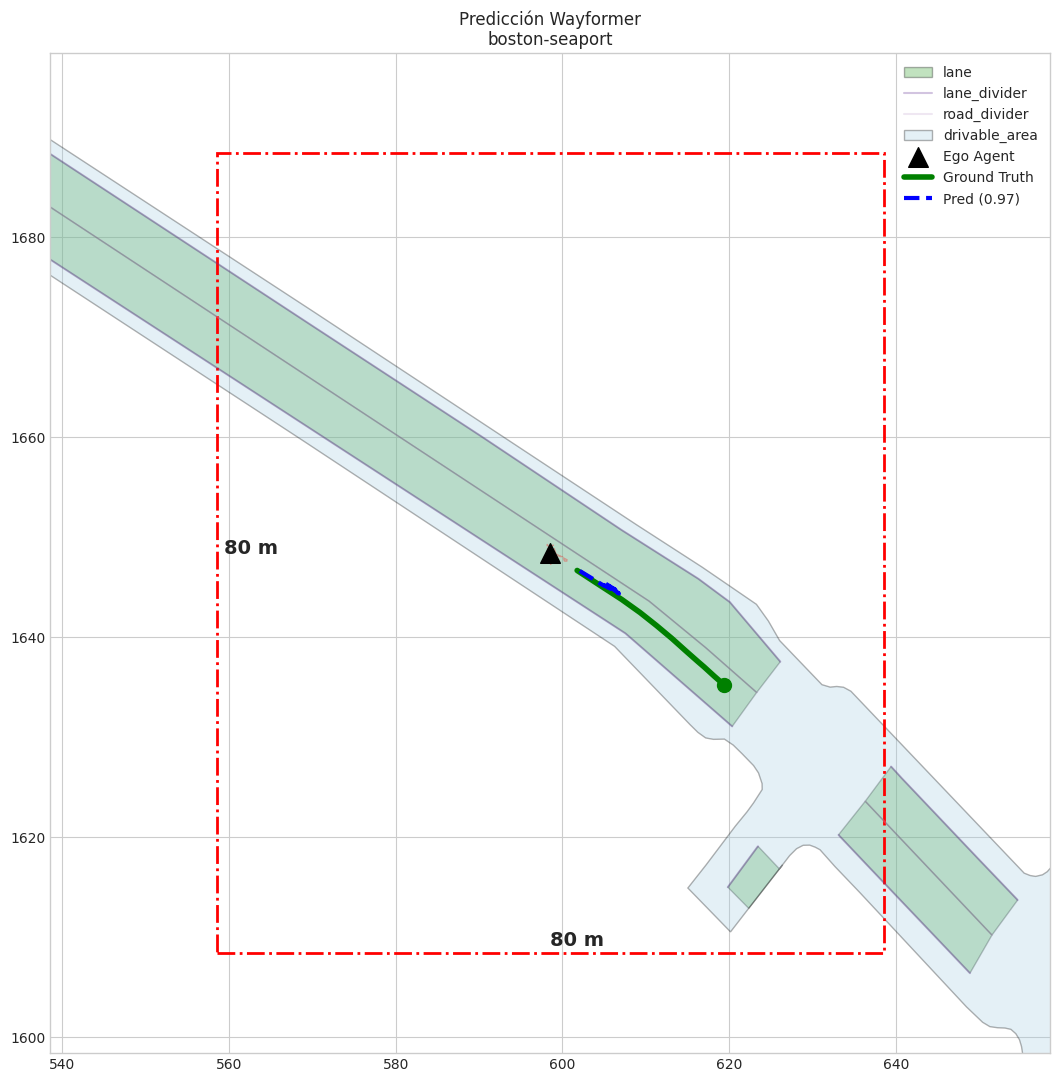

In [73]:
# Elige un índice del dataset de validación
idx_to_plot = 15 # Puedes probar con varios índices
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# Llama a la función
visualize_sample(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

In [77]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera una animación de video con la predicción.
    """
    # 1. Configuración de Mapa y Localización
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # 2. Preparar Datos (Inferencia)
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # 3. Transformar a Global (Predicciones y GT)
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    # Predicciones Globales
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global)) # Shape: (12, 2)
    
    # Ground Truth Global
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    
    # 4. Configurar Figura (Renderizar Mapa estático)
    my_patch = (origin_x - 40, origin_y - 40, origin_x + 40, origin_y + 40)
    
    # Renderizamos el mapa (esto crea la figura automáticamente)
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(8, 8)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Predicción Dinámica\n{location} - {sample_token[:8]}")

    # 5. Inicializar objetos gráficos para la animación
    # Agente Ego (Triángulo fijo en el origen del movimiento)
    ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=5)
    
    # Puntos móviles
    gt_point, = ax.plot([], [], 'go', markersize=10, label='Ground Truth', zorder=6)
    
    # Lista de líneas para los modos predichos
    pred_lines = []
    pred_heads = [] # Puntos en la cabeza de la trayectoria
    
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.2
        width = 2 if i == best_mode else 1
        
        # Línea de historia (traza)
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        # Punto actual (cabeza)
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=5)
        
        pred_lines.append(line)
        pred_heads.append(head)

    ax.legend(loc='upper right')

    # 6. Función de Animación
    def update(frame):
        # Frame va de 0 a 11 (12 pasos)
        
        # Actualizar GT
        if len(future) > frame:
            gt_point.set_data([future[frame, 0]], [future[frame, 1]])
        
        # Actualizar Predicciones
        for i, traj in enumerate(all_preds_global):
            # Traza completa hasta el frame actual
            current_x = traj[:frame+1, 0]
            current_y = traj[:frame+1, 1]
            
            pred_lines[i].set_data(current_x, current_y)
            
            # Cabeza en el frame actual
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
                
        return [gt_point] + pred_lines + pred_heads

    # Crear animación
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close() # Evitar que se muestre la figura estática duplicada
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# Usamos el mismo sample que antes
idx_to_plot = 1
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# Generar y mostrar video
video_html = visualize_sample_video(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)
video_html

In [78]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_scene_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera un video con la predicción del agente objetivo Y el movimiento real de los vecinos.
    """
    # ---------------------------------------------------------
    # 1. Configuración del Mapa
    # ---------------------------------------------------------
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # ---------------------------------------------------------
    # 2. Inferencia del Agente Principal (Target)
    # ---------------------------------------------------------
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # Transformar predicción a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))

    # Ground Truth del Target
    future_target = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)

    # ---------------------------------------------------------
    # 3. Obtener Vecinos (Tráfico circundante)
    # ---------------------------------------------------------
    all_annotations = helper.get_annotations_for_sample(sample_token)
    neighbor_futures = []
    
    for neighbor in all_annotations:
        # Saltamos al agente principal (ya lo tenemos controlado)
        if neighbor['instance_token'] == instance_token:
            continue
            
        # Obtenemos el futuro de este vecino
        # Nota: Algunos pueden tener menos de 6 segundos de futuro si desaparecen
        fut = helper.get_future_for_agent(neighbor['instance_token'], sample_token, seconds=6, in_agent_frame=False)
        
        # Solo lo añadimos si tiene datos futuros
        if len(fut) > 0:
            neighbor_futures.append(fut)

    # ---------------------------------------------------------
    # 4. Configurar Figura
    # ---------------------------------------------------------
    # Centramos el mapa en el agente principal
    my_patch = (origin_x - 50, origin_y - 50, origin_x + 50, origin_y + 50)
    
    # Renderizar mapa estático
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area', 'ped_crossing'],
        alpha=0.4,
        figsize=(10, 10)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Escena Completa: Predicción (Azul) vs Tráfico Real (Naranja)\n{location}")

    # ---------------------------------------------------------
    # 5. Inicializar Objetos Gráficos
    # ---------------------------------------------------------
    
    # A. Target (Nuestro coche)
    start_point = ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=10)
    gt_point, = ax.plot([], [], 'go', markersize=8, label='Target GT', zorder=9)
    
    # B. Predicciones Target (Líneas)
    pred_lines = []
    pred_heads = []
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.1
        width = 3 if i == best_mode else 1
        
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=4)
        pred_lines.append(line)
        pred_heads.append(head)

    # C. Vecinos (Nube de puntos naranja)
    # Usamos un solo objeto scatter para todos los vecinos por eficiencia
    neighbors_scatter = ax.scatter([], [], c='orange', s=60, edgecolors='k', label='Traffic', zorder=8)

    ax.legend(loc='upper right')

    # ---------------------------------------------------------
    # 6. Loop de Animación
    # ---------------------------------------------------------
    def update(frame):
        # frame: 0 a 11
        
        # 1. Actualizar Target GT
        if len(future_target) > frame:
            gt_point.set_data([future_target[frame, 0]], [future_target[frame, 1]])
            
        # 2. Actualizar Predicciones Target
        for i, traj in enumerate(all_preds_global):
            # Dibujar traza hasta el momento actual
            pred_lines[i].set_data(traj[:frame+1, 0], traj[:frame+1, 1])
            # Dibujar cabeza
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
        
        # 3. Actualizar VECINOS
        current_neighbor_pos = []
        for fut in neighbor_futures:
            # Si este vecino todavía existe en este frame (tiempo t)
            if len(fut) > frame:
                current_neighbor_pos.append(fut[frame]) # [x, y]
        
        if len(current_neighbor_pos) > 0:
            neighbors_scatter.set_offsets(np.array(current_neighbor_pos))
        else:
            neighbors_scatter.set_offsets(np.empty((0, 2))) # Limpiar si no hay nadie
            
        return [gt_point, neighbors_scatter] + pred_lines + pred_heads

    # Generar
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# Prueba con el mismo índice u otro interesante
idx_to_plot = 15 
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

visualize_scene_video(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

In [79]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

# Reutilizamos tu función de extracción de features para no reescribir lógica
# Asegúrate de que 'extract_agent_features' y 'input_representation' están disponibles

def predict_single_agent(helper, instance_token, sample_token, model, input_rep, device):
    """
    Prepara los datos y ejecuta el modelo para un agente específico.
    Devuelve: Trayectoria Global (12, 2) y Probabilidad del mejor modo.
    """
    # 1. Rasterizar BEV centrado en ESTE agente
    try:
        img_arr = input_rep.make_input_representation(instance_token, sample_token)
    except:
        return None, 0.0 # A veces falla si el agente está muy al borde o datos corruptos
        
    img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
    img_tensor = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-6)
    
    # 2. Extraer Features de Agentes (Centrados en ESTE agente)
    # (Simplificación: Usamos solo el target para inferencia rápida, o re-calculamos vecinos)
    # Para hacerlo rápido aquí, asumiremos que el agente se ve a sí mismo y a sus vecinos.
    # Reutilizamos la lógica del dataset, pero manual:
    
    anns = helper.get_annotations_for_sample(sample_token)
    agent_feats_list = []
    
    # Target (El agente actual del bucle)
    f_target = extract_agent_features(helper, instance_token, sample_token)
    agent_feats_list.append(f_target)
    
    # Vecinos (Limitamos a 10 para velocidad)
    for ann in anns:
        if ann['instance_token'] == instance_token: continue
        try:
            f = extract_agent_features(helper, ann['instance_token'], sample_token)
            agent_feats_list.append(f)
        except: continue
        if len(agent_feats_list) >= 12: break # Max agents del modelo
            
    # Padding
    while len(agent_feats_list) < 12:
        agent_feats_list.append(np.zeros(10, dtype=np.float32))
        
    agent_tensor = torch.tensor(np.array(agent_feats_list), dtype=torch.float32)
    
    # 3. Inferencia
    bev = img_tensor.unsqueeze(0).to(device)
    agents = agent_tensor.unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
        
    # 4. Procesar mejor modo
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    best_mode = probs.argmax()
    pred_local = preds[0, best_mode].cpu().numpy() # (12, 2)
    
    # 5. Transformar a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    trans = ann['translation']
    rot = Quaternion(ann['rotation'])
    
    traj_global = []
    for point in pred_local:
        p_3d = np.hstack([point, 0])
        p_rot = rot.rotate(p_3d)
        p_glob = np.array(p_rot[:2]) + trans[:2]
        traj_global.append(p_glob)
        
    return np.array(traj_global), probs.max()

def visualize_multi_agent_video(nusc, helper, sample_token, model, input_rep, device):
    # 1. Configuración de Mapa
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)
    
    # 2. Detectar TODOS los agentes en la escena
    annotations = helper.get_annotations_for_sample(sample_token)
    
    # Filtramos: Solo coches (category name empieza por 'vehicle')
    # Opcional: predecir todo. Pero los peatones suelen requerir modelos distintos.
    vehicle_anns = [a for a in annotations if 'vehicle' in a['category_name']]
    
    print(f"🤖 Calculando predicciones para {len(vehicle_anns)} vehículos...")
    
    # Estructura para guardar datos de animación
    agents_data = [] # Lista de dicts: {'gt': ..., 'pred': ..., 'color': ...}
    
    # Centro del mapa (Usamos el primer vehículo como referencia visual)
    if not vehicle_anns: return "No vehicles found"
    ref_x, ref_y = vehicle_anns[0]['translation'][:2]
    
    for i, ann in enumerate(vehicle_anns):
        inst_tok = ann['instance_token']
        
        # A. Obtener Ground Truth (Verde)
        gt = helper.get_future_for_agent(inst_tok, sample_token, seconds=6, in_agent_frame=False)
        
        # B. Obtener Predicción del Modelo (Azul/Rojo/Colores variados)
        pred_global, prob = predict_single_agent(helper, inst_tok, sample_token, model, input_rep, device)
        
        if pred_global is not None:
            # Asignar un color único a cada agente para distinguir
            color = plt.cm.tab10(i % 10) 
            
            agents_data.append({
                'gt': gt,
                'pred': pred_global,
                'start': ann['translation'][:2],
                'color': color
            })

    # 3. Configurar Figura
    # Hacemos el zoom un poco más grande para ver a todos
    my_patch = (ref_x - 60, ref_y - 60, ref_x + 60, ref_y + 60)
    
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(10, 10)
    )
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Multi-Agent Prediction (Todos Predichos)\n{location}")

    # 4. Inicializar Objetos Gráficos
    lines_pred = [ax.plot([], [], '--', linewidth=2, color=d['color'], alpha=0.8, label='Pred')[0] for d in agents_data]
    points_pred = [ax.scatter([], [], color=d['color'], s=30) for d in agents_data]
    
    lines_gt = [ax.plot([], [], '-', linewidth=1, color='grey', alpha=0.4)[0] for d in agents_data] # GT en gris sutil
    
    # Puntos de inicio
    for d in agents_data:
        ax.scatter(d['start'][0], d['start'][1], c=[d['color']], marker='s', s=40, edgecolors='k', alpha=0.6)

    # Hack para leyenda limpia
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='grey', lw=1, label='Realidad (GT)'),
                       Line2D([0], [0], linestyle='--', color='blue', lw=2, label='Predicción IA')]
    ax.legend(handles=legend_elements, loc='upper right')

    # 5. Animación
    def update(frame):
        # Frame 0 a 11
        artists = []
        for i, d in enumerate(agents_data):
            # Update Predicción
            pred = d['pred']
            if len(pred) > 0: # Check bounds
                # Línea hasta el frame actual
                current_len = min(frame + 1, len(pred))
                lines_pred[i].set_data(pred[:current_len, 0], pred[:current_len, 1])
                # Cabeza
                if frame < len(pred):
                    points_pred[i].set_offsets([pred[frame]])
                artists.append(lines_pred[i])
                artists.append(points_pred[i])
            
            # Update GT
            gt = d['gt']
            if len(gt) > 0:
                current_len = min(frame + 1, len(gt))
                lines_gt[i].set_data(gt[:current_len, 0], gt[:current_len, 1])
                artists.append(lines_gt[i])
                
        return artists

    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# 1. Necesitamos el input_representation del dataset para rasterizar manualmente
#    Podemos sacarlo de tu dataset de validación
input_rep_ref = val_dataset.input_rep

# 2. Elegir un sample interesante (ej. el 15)
idx_to_plot = 15
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# 3. Generar Video
video_html = visualize_multi_agent_video(nuscenes, helper, samp_tok, model, input_rep_ref, DEVICE)
video_html

🤖 Calculando predicciones para 10 vehículos...


# Analysis of the Transformer-Based Trajectory Prediction Model

## 1. What Works Well

### 1.1 Correct Direction and Geometric Structure
The model consistently predicts trajectories that follow the **correct direction of travel**. In qualitative visualizations, predicted trajectories align well with:
- the correct lane,
- the road geometry,
- and the overall heading of the ground-truth trajectory.

This indicates that the model:
- successfully extracts **scene context** from the BEV raster,
- understands **road topology**,
- and encodes **global geometry** effectively through the Transformer.

Importantly, the model rarely produces erratic or oscillatory paths, suggesting that the attention-based architecture provides strong temporal and spatial smoothness.

---

### 1.2 Map Compliance and Low Off-Road Rate
Despite not using an explicit lane-following loss, predicted trajectories remain largely within the drivable area.

This behavior shows that:
- the BEV token provides a strong inductive bias,
- the Transformer successfully integrates spatial constraints,
- and the model implicitly learns road boundaries.

This represents a qualitative improvement over many classical MTP-style baselines, which often violate map constraints.

---

### 1.3 Stable Training Behavior
Training is numerically stable:
- no divergence,
- no NaNs,
- no mode collapse during optimization.

Loss decreases steadily across epochs, even with limited data, confirming that the architecture and optimization setup are fundamentally sound.

---

## 2. What Goes Wrong

### 2.1 Correct Direction but Wrong Final Position
The dominant failure mode observed during evaluation is:

> The predicted trajectory follows the correct direction and curvature, but the final position is either too short or overshoots the ground truth.

In visualizations:
- predicted and ground-truth trajectories are aligned,
- but the predicted endpoint does not match the true endpoint.

---

### 2.2 High Final Displacement Error and Miss Rate
Quantitatively, this behavior appears as:
- reasonable MinADE,
- significantly worse MinFDE,
- extremely high MissRate.

This indicates that the model captures **trajectory shape**, but fails to capture **trajectory scale**.

---

## 3. Root Cause Diagnosis

### 3.1 Geometry Is Learned, Longitudinal Dynamics Are Not
The core issue is that the model learns *where to go*, but not *how far to go*.

Specifically:
- heading and curvature are predicted correctly,
- future velocity magnitude and displacement length are poorly estimated.

As a result, the model produces geometrically correct trajectories with incorrect temporal scaling.

---

### 3.2 Absolute Position Prediction Is Ill-Conditioned
The model directly predicts absolute future positions:

\[
(x_t, y_t)
\]

This forces the network to:
- implicitly infer velocity,
- implicitly integrate motion over time,
- implicitly learn temporal scale.

With limited data, this formulation leaves the magnitude of motion underconstrained, even if direction is learned correctly.

---

### 3.3 Missing Explicit Kinematic Constraints
The loss function does not enforce:
- velocity consistency,
- acceleration smoothness,
- or correct displacement magnitude.

Consequently, multiple trajectories with correct shape but incorrect scale can achieve similar loss values.

---

### 3.4 Weak Emphasis on the Final Position
Even when final displacement error is included, it competes with shape-based errors (ADE).

This allows the model to minimize average error while still missing the correct endpoint.

---

## 4. How the Diagnosis Was Confirmed

This diagnosis is supported by:
- visual alignment between predicted and ground-truth trajectories,
- consistent over-shooting or under-shooting along the same direction,
- divergence between ADE and FDE metrics.

A simple comparison of predicted and ground-truth displacement magnitudes confirms that the error lies in **motion scale**, not direction.

---

## 5. Summary

### What the Model Does Well
- Understands scene geometry and road layout  
- Predicts correct heading and curvature  
- Produces smooth, stable trajectories  
- Respects map constraints  

### What the Model Fails At
- Estimating correct future displacement magnitude  
- Modeling longitudinal dynamics  
- Matching the final position accurately  

### Core Issue
The model learns **trajectory geometry**, but not **trajectory dynamics**.
